<h1 align=center><font size = 5>AI SATURDAY LAGOS COHORT 8</font></h1>   

<h1 align=center><font size = 5>TEAM JOHNSON-SIRLEAF </font></h1>  
<h2 align=center><font size = 6>MACHINE LEARNING APPROACH TO
PREDICTING DIABETES RISKS USING LIGHTGBM</font></h2>

<h5 align=center><font size = 2>Data Source: <a href="https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset" target="_blank">Kaggle.<a/></font></h5>

## DATA PREPARATION

In [24]:
# import libraries

import numpy as np                      # for mahematical operations
import pandas as pd                     # for data manipulation and cleaning
import seaborn as sns                   # for data visulization
import plotly.express as px             # for data visulization
import matplotlib.pyplot as plt         # for data visulization

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### Data Loading

In [25]:
# Read in dataset
df = pd.read_csv('../data/diabetes_prediction_dataset.csv')

In [26]:
df.head(3)

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0

In [27]:
# Proof of Imbalanced Dataset
Data_diabetic = df[df["diabetes"] == 1]
Data_not_diabetic = df[df["diabetes"] == 0]
print(f"The number of data points for non diabetic patients is {Data_not_diabetic.shape}")
print(f"The number of data points for diabetic patients is {Data_diabetic.shape}")

The number of data points for non diabetic patients is (91500, 9)
The number of data points for diabetic patients is (8500, 9)


### Data Dictionary

| variable       | class     | description                                                                  |
|:---------------|:----------|:-----------------------------------------------------------------------------|
| Gender               | character | Biological sex of the individual  |
| Age                  | numeric   | Age of the individual  |
| Hypertension         | numeric   | 0 = No Hypertension / 1 = Has Hypertension|
| Heart_disease        | numeric   | 0 = No Heart disease / 1 = Has Heart disease|
| Smoking_history      | character | 5 categories i.e not current,former,No Info,current,never and ever |
| bmi                  | numeric   | Body Mass Index, a measure of body fat based on weight and height|
| HbA1c_level          | numeric   | Hemoglobin A1c, a measure of a person's average blood sugar level over the past 2-3 months|
| Blood_glucose_level  | numeric | Amount of glucose in the bloodstream at a given time|
| Diabetes             | numeric | 0 indicates absence of diabetes, 1 indicates presence of Diabetes|

In [28]:
# check the data types of each features
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [29]:
# check the shape of the data
df.shape

(100000, 9)

In [30]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [32]:
# Checking statistics of the numeric features
df.describe()

age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           140.000000       0.000000  
75%         6.200000           159.000000       0.000000  
max         9.000000           300.000000       1.000000

### Data Wrangling

In [33]:
# save a copy of the data
df_copy = df.copy('Dataset/diabetes_prediction_dataset.csv')

In [34]:
def df_wrangle(df, dtype_convert, OneHot_cols):
    '''
    This function wrangles (cleans) our dataset by correcting datypes and One-Hot
    encoding dpecified columns
    
    Inputs
    df: (dataframe), dataframe to wrangle
    dtype_convert: (dictionary), pairs of column, dtype to convert to
    OneHot_col: (list), columns in the dataframe to One-Hot encode
    
    Output
    df: (dataframe), wrangled (cleaned) dataframe
    '''
    
    # convert datatypes to correct formats
    for col, dtype in dtype_convert.items():
        df[col] = df[col].astype(dtype)
        
    # One_Hot encode neccesary columns
    
    # Initialize the One-Hot Encoder
    encoder = OneHotEncoder()
    
    # One-Hot encode each column
    for col in OneHot_cols:
        # variable to store new column names
        df_col_name = []
        
        # unique values in current column
        vals = df[col].unique()             

        for val in vals:
            # replace spaces in values with underscore
            val = val.replace(' ', '_')
            
            # combine initial column name and current value as new column name
            df_col_name.append(col+'_'+val) 
                                            
        # encode the columns
        encoded_df = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray())
        
        # rename the new columns
        encoded_df.columns = df_col_name
        
        # add new columns to dataframe
        df = df.join(encoded_df)

    # drop the initial columns
    df.drop(OneHot_cols, axis=1, inplace=True)
    
    return df

In [35]:
df = df_wrangle(df, {'age':'int'}, ['gender', 'smoking_history'])

In [36]:
df.head()

age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0   80             0              1  25.19          6.6                  140   
1   54             0              0  27.32          6.6                   80   
2   28             0              0  27.32          5.7                  158   
3   36             0              0  23.45          5.0                  155   
4   76             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  gender_Other  smoking_history_never  \
0         0            1.0          0.0           0.0                    0.0   
1         0            1.0          0.0           0.0                    1.0   
2         0            0.0          1.0           0.0                    0.0   
3         0            1.0          0.0           0.0                    0.0   
4         0            0.0          1.0           0.0                    0.0   

   smoking_history_No_Info  smoking_history_current  smoking_history_former  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      1.0                      0.0                     0.0   
4                      1.0                      0.0                     0.0   

   smoking_history_ever  smoking_history_not_current  
0                   1.0                          0.0  
1                   0.0                          0.0  
2                   1.0                          0.0  
3                   0.0                          0.0  
4                   0.0                          0.0

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          100000 non-null  int64  
 1   hypertension                 100000 non-null  int64  
 2   heart_disease                100000 non-null  int64  
 3   bmi                          100000 non-null  float64
 4   HbA1c_level                  100000 non-null  float64
 5   blood_glucose_level          100000 non-null  int64  
 6   diabetes                     100000 non-null  int64  
 7   gender_Female                100000 non-null  float64
 8   gender_Male                  100000 non-null  float64
 9   gender_Other                 100000 non-null  float64
 10  smoking_history_never        100000 non-null  float64
 11  smoking_history_No_Info      100000 non-null  float64
 12  smoking_history_current      100000 non-null  float64
 13  

In [38]:
df.describe()

age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.875660       0.07485       0.039420      27.320767   
std        22.535417       0.26315       0.194593       6.636783   
min         0.000000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  gender_Female  \
count  100000.000000        100000.000000  100000.000000  100000.000000   
mean        5.527507           138.058060       0.085000       0.585520   
std         1.070672            40.708136       0.278883       0.492635   
min         3.500000            80.000000       0.000000       0.000000   
25%         4.800000           100.000000       0.000000       0.000000   
50%         5.800000           140.000000       0.000000       1.000000   
75%         6.200000           159.000000       0.000000       1.000000   
max         9.000000           300.000000       1.000000       1.000000   

         gender_Male   gender_Other  smoking_history_never  \
count  100000.000000  100000.000000          100000.000000   
mean        0.414300       0.000180               0.358160   
std         0.492603       0.013415               0.479462   
min         0.000000       0.000000               0.000000   
25%         0.000000       0.000000               0.000000   
50%         0.000000       0.000000               0.000000   
75%         1.000000       0.000000               1.000000   
max         1.000000       1.000000               1.000000   

       smoking_history_No_Info  smoking_history_current  \
count            100000.000000            100000.000000   
mean                  0.092860                 0.040040   
std                   0.290238                 0.196054   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                   1.000000                 1.000000   

       smoking_history_former  smoking_history_ever  \
count           100000.000000          100000.00000   
mean                 0.093520               0.35095   
std                  0.291161               0.47727   
min                  0.000000               0.00000   
25%                  0.000000               0.00000   
50%                  0.000000               0.00000   
75%                  0.000000               1.00000   
max                  1.000000               1.00000   

       smoking_history_not_current  
count                 100000.00000  
mean                       0.06447  
std                        0.24559  
min                        0.00000  
25%                        0.00000  
50%                        0.00000  
75%                        0.00000  
max                        1.00000

### Defining Model Variables and Target

In [39]:
X = df.drop('diabetes', axis=1)
X.shape

(100000, 15)

In [40]:
y = df['diabetes']
y.shape

(100000,)

## Data Splitting for Model Building

### Method 1 - Train, Dev, Test

For the first method of our data splitting, the dataset contains 100,000 samples of data. The splitting would be done in the ratio 90:5:5, which implies 90000 data point for training, 5000 data points for dev set and test sets respectively

This is because 5% (5,000) samples is enough for each of our development and test sets.

NB: Both dev set and test sets are referred to as validation dataset in our code.

In [68]:
from sklearn.model_selection import train_test_split

#### Training set

In [69]:
# 90,000 data points for training of dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(90000, 15)
(90000,)
(10000, 15)
(10000,)


##### Validation Set - Dev and Test set
We are going to use about 10,000 data points for our validation test set. The `X_dev` and `y_dev` is the training dataset in the validation cycle, while the `X_test` and `y_test` are the test dataset in the validation cycle.

In [70]:
X_dev, X_test, y_dev, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=123)

In [71]:
print(f'Shape of X_train {X_train.shape}    Shape of y_train {y_train.shape}')
print(f'Shape of X_dev {X_dev.shape}       Shape of y_dev {y_dev.shape}')
print(f'Shape of X_test {X_test.shape}      Shape of y_test {y_test.shape}')

Shape of X_train (90000, 15)    Shape of y_train (90000,)
Shape of X_dev (5000, 15)       Shape of y_dev (5000,)
Shape of X_test (5000, 15)      Shape of y_test (5000,)


##### Model Building

In [72]:
from lightgbm import LGBMClassifier as lgb
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import time
from sklearn.metrics import roc_auc_score, make_scorer, f1_score

##### Model Evaluation

We are going to carry out predictions on  our dev sets and also use our train set to verify if our model is overfitting or not. Then we would use the test evaluate our modeling finally on an entirely unseen data.

### Create a simple Light GBM Model and evaluate performance.

In [78]:
model = lgb()

# start = time()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
score = cross_val_score(model, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)

score = f1_score['LGBM'] = np.mean(score).round(3)

print(f"Mean F1 Score is {score}\n Std: {np.std(score):.3f}")

[LightGBM] [Info] Number of positive: 6106, number of negative: 65894
[LightGBM] [Info] Number of positive: 6106, number of negative: 65894
[LightGBM] [Info] Number of positive: 6106, number of negative: 65894
[LightGBM] [Info] Number of positive: 6105, number of negative: 65895
[LightGBM] [Info] Number of positive: 6105, number of negative: 65895
[LightGBM] [Info] Number of positive: 6106, number of negative: 65894
[LightGBM] [Info] Number of positive: 6106, number of negative: 65894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084806 -> initscore=-2.378775[LightGBM] [Info] Number of positive: 6106, number of negative: 65894

[LightGB

TypeError: 'function' object does not support item assignment

Specify parameters for LightGBM model building.

In [51]:
# parameters = {
#     "objective": "binary",
#     "metric": "auc",
#     "is_unbalance": "true",
#     "boosting":"gbdt",
#     "num_leaves": 63,
#     "feature_fraction": 0.5,
#     "bagging_fraction": 0.5,
#     "bagging_freq": 20,
#     "learning_rate": 0.01,
#     "verbose": -1
# }

In [58]:
# lgb_model = lgb.train(parameters,
#                       train_data,
#                       valid_sets=valid_data,
#                       num_boost_round = 500,
#                       callbacks=[lgb.early_stopping(stopping_rounds=100)]                   
#                       )

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's auc: 0.980421


In [59]:
# y_train_pred = lgb_model.predict(X_train)
# y_valid_pred = lgb_model.predict(X_dev)

# print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
#                                                     roc_auc_score(y_dev, y_valid_pred)))

AUC Train: 0.9854
AUC Valid: 0.9804


### Find prediction for Test dataset.

In [ ]:
# y_test_pred = lgb_model.predict(X_test)

In [66]:
# f1_test_score = f1_score(y_test, y_test_pred)

# print("F1 Score on Test Set:", f1_test_score)

#### Confusion Matrix for Method 1

findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


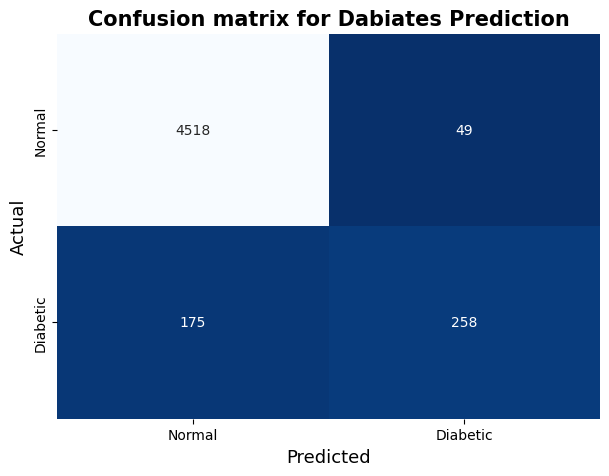

In [ ]:
color  = ['#3355FF','#00FF00','#0D004D','#00bfff','#ffcc99','#006600']
# sns.countplot(x='Purchased', data = insurance, palette = color[2:4]);


def ConfusionMatrix(ytest, ypred, label: [str, str] = ["Negative", "Positive"]):
    "A beautiful confusion matrix function to check the model performance"
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(ytest, ypred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot = True, cbar = False, fmt = 'd', cmap = 'Blues_r')
    plt.xlabel('Predicted',font = 'Century Gothic', fontsize = 13)
    plt.ylabel('Actual', font = 'Century Gothic', fontsize = 13)
    plt.xticks([0.5, 1.5], label)
    plt.yticks([0.5, 1.5], label)
    plt.title('Confusion matrix for Dabiates Prediction', font = "Century Gothic", fontsize = 15,fontweight = 'bold');


ConfusionMatrix(y_test, y_test_pred, label = ["Normal", "Diabetic"])

### Method 2 - Cross Validation

We have a total of 10,000 datasets, we would carry out cross validation to make sure we immerse the whole of our dataset into model training and test. For this we would have a kfold of 5.

In [ ]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Cross Validation using F1 score as evaluation metrics

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score

model = LogisticRegression(max_iter=1000)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)


f1_scorer = make_scorer(f1_score, average="binary")
cross_val_result_arr = cross_val_score(model, X_train_val_scaled, y_train_val, cv=kf, scoring=f1_scorer)

# Printing the results
print("Cross-Validation Results:", cross_val_result_arr)
print(f"Mean F1 score: {cross_val_result_arr.mean():.2f}")
print(f"Standard deviation of F1 score: {cross_val_result_arr.std():.2f}")

Cross-Validation Results: [0.73693231 0.73778156 0.72024327 0.72703863 0.73589744]
Mean F1 score: 0.73
Standard deviation of F1 score: 0.01


In [ ]:
## Using on test dataset
model = LogisticRegression()

model.fit(X_train_val_scaled, y_train_val)

y_pred = model.predict(scaler.transform(X_test))

f1_test_score = f1_score(y_test, y_pred, average='binary')

print("F1 Score on Test Set:", f1_test_score)

F1 Score on Test Set: 0.7204803202134756


### Confusion Matrix

findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


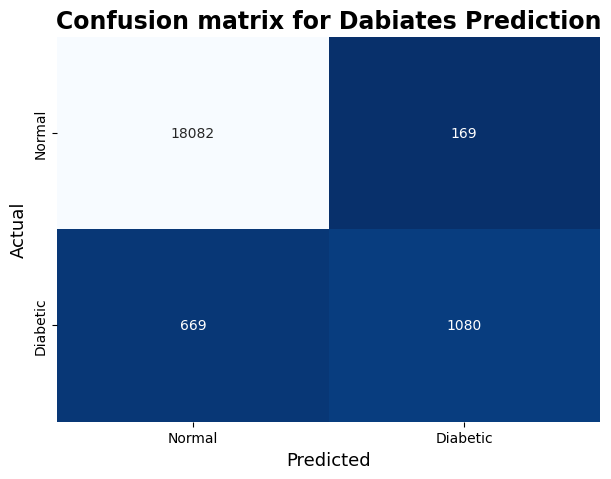

In [ ]:
color  = ['#3355FF','#00FF00','#0D004D','#00bfff','#ffcc99','#006600']
# sns.countplot(x='Purchased', data = insurance, palette = color[2:4]);


def ConfusionMatrix(ytest, ypred, label: [str, str] = ["Negative", "Positive"]):
    "A beautiful confusion matrix function to check the model performance"
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(ytest, ypred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot = True, cbar = False, fmt = 'd', cmap = 'Blues_r')
    plt.xlabel('Predicted',font = 'Century Gothic', fontsize = 13)
    plt.ylabel('Actual', font = 'Century Gothic', fontsize = 13)
    plt.xticks([0.5, 1.5], label)
    plt.yticks([0.5, 1.5], label)
    plt.title('Confusion matrix for Dabiates Prediction', font = "Century Gothic", fontsize = 17,fontweight = 'bold');


ConfusionMatrix(y_test, y_pred, label = ["Normal", "Diabetic"])

### Interpretation of the Logistic Regression Model Evaluation Performance
There are `18082` True Positives (TP):predicting that patients are  not diabetic and truly the patients are not diabetic.

There `669` False Positives(TP):predicting that the patients are not diabetic meanwhile the patients are diabetic.

There are `1080` True Negative(TN): predicting that the patients are diabetic and they actually diabetic.

There are also `669` False Negative(FN): predicting that the patients are diabetic meanwhile they are actually not diabetic.

Based on the confusion matrix, we can see that although performed very well in predicting the positive and negative cases, it can still be better.

### Polynomial Engineering for Model Complexity.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LogisticRegression(**kwargs))

In [ ]:
X_train_dev = pd.concat([X_train,X_dev])

In [ ]:
y_train_dev = pd.concat([y_train,y_dev])

In [ ]:
X_train_dev_scaled = StandardScaler().fit_transform(X_train_dev)

In [ ]:
degree = np.arange(1,3)

In [ ]:
train_score, val_score = validation_curve(PolynomialRegression(degree, max_iter=100000),
                                          X_train_dev_scaled,y_train_dev,
                                          param_name='polynomialfeatures__degree',
                                          param_range=degree,cv=5)

NameError: name 'validation_curve' is not defined

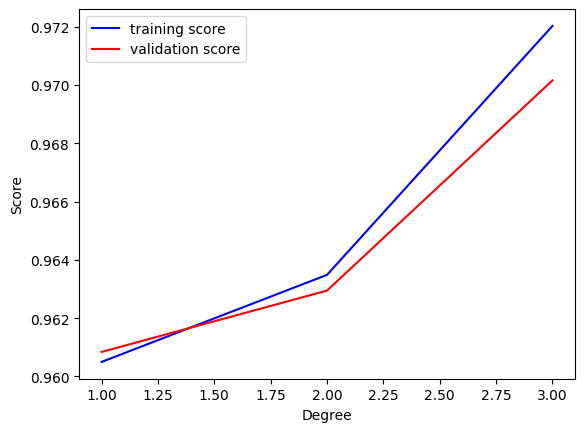

In [ ]:
plt.plot(degree,np.median(train_score,1),'b',label='training score')
plt.plot(degree,np.median(val_score,1),'r',label='validation score')
plt.xlabel('Degree')
plt.ylabel('Score')
plt.legend();

The plot above shows that our model can still improve up to around 97% using 3rd order polynomial feature genration.

They is posibility to achieve more than this. The model was built only up to the 3rd degree polynomial because of the long time needed for higher orders